In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")


In [2]:
depth_df = pd.read_csv("/content/drive/MyDrive/ROZCAPITAL/depth20_1000ms/BNBFDUSD_20250314.txt", header=None)
depth_df.columns = [col.strip() for col in depth_df.iloc[0]]
depth_df = depth_df[1:].reset_index(drop=True)

In [3]:
trade_df = pd.read_csv("/content/drive/MyDrive/ROZCAPITAL/aggTrade/BNBFDUSD_20250314.txt", header=None)
trade_df.columns = [col.strip() for col in trade_df.iloc[0]]
trade_df = trade_df[1:].reset_index(drop=True)

In [4]:
def engineer_orderbook_features(depth_df):
    features = pd.DataFrame(index=depth_df.index)
    features["mid_price"] = (depth_df["BidPriceL1"] + depth_df["AskPriceL1"]) / 2
    features["spread"] = depth_df["AskPriceL1"] - depth_df["BidPriceL1"]
    features["imbalance_lvl1"] = (
        (depth_df["BidQtyL1"] - depth_df["AskQtyL1"]) /
        (depth_df["BidQtyL1"] + depth_df["AskQtyL1"])
    )
    features["microprice"] = (
        (depth_df["BidPriceL1"] * depth_df["AskQtyL1"] + depth_df["AskPriceL1"] * depth_df["BidQtyL1"]) /
        (depth_df["BidQtyL1"] + depth_df["AskQtyL1"])
    )

    bid_qty_cols = [f"BidQtyL{i}" for i in range(1, 21)]
    ask_qty_cols = [f"AskQtyL{i}" for i in range(1, 21)]
    features["cum_bid_qty"] = depth_df[bid_qty_cols].sum(axis=1)
    features["cum_ask_qty"] = depth_df[ask_qty_cols].sum(axis=1)
    features["sloped_depth_bid"] = depth_df[bid_qty_cols[:5]].mean(axis=1) / (depth_df[bid_qty_cols[-5:]].mean(axis=1) + 1e-6)
    features["sloped_depth_ask"] = depth_df[ask_qty_cols[:5]].mean(axis=1) / (depth_df[ask_qty_cols[-5:]].mean(axis=1) + 1e-6)
    return features

In [5]:
def add_volatility_features(features):
    features["log_return"] = np.log(features["mid_price"] / features["mid_price"].shift(1))
    features["volatility_10s"] = features["log_return"].rolling(10).std()
    features["volatility_30s"] = features["log_return"].rolling(30).std()
    return features


In [6]:
def engineer_trade_features(trade_df, resample_to="1S"):
    trade_df = trade_df.copy()
    trade_df.set_index('Time', inplace=True)

    if "IsMarketMaker" in trade_df.columns:
        trade_df["signed_volume"] = np.where(trade_df["IsMarketMaker"], -trade_df["Quantity"], trade_df["Quantity"])
    else:
        trade_df["signed_volume"] = trade_df["Quantity"]

    resampled = trade_df.resample(resample_to).agg({
        "Price": "mean",
        "Quantity": "sum",
        "signed_volume": "sum"
    })
    resampled["vwap"] = (trade_df["Price"] * trade_df["Quantity"]).resample(resample_to).sum() / trade_df["Quantity"].resample(resample_to).sum()
    resampled["volume_imbalance"] = resampled["signed_volume"] / (resampled["Quantity"] + 1e-6)
    return resampled


In [7]:
def merge_depth_trade_features(depth_features, trade_features):
    return depth_features.join(trade_features, how='inner').dropna()

In [8]:
def normalize_and_reduce(features, use_pca=False, n_components=3):
    features = features.dropna()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    if use_pca:
        pca = PCA(n_components=n_components)
        reduced = pca.fit_transform(scaled)
        return reduced, features.index, features, pca
    else:
        return scaled, features.index, features, None

In [9]:
def run_kmeans(data, k=4):
    return KMeans(n_clusters=k, random_state=42).fit_predict(data)

def run_gmm(data, k=4):
    return GaussianMixture(n_components=k, random_state=42).fit_predict(data)

def run_hdbscan(data, min_cluster_size=100):
    return hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(data)

In [10]:
def plot_clusters_fancy(time_index, labels, title="Detected Regimes Over Time"):
    plt.figure(figsize=(14, 5))
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.plot(time_index[mask], [label]*sum(mask), '|', markersize=10, color=colors(i), label=f'Regime {label}')

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Regime")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [11]:
def plot_tsne_2d(data, labels, title="t-SNE Cluster View"):
    embedding = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette='tab10', s=20)
    plt.title(title)
    plt.legend(title="Regime")
    plt.grid(True)
    plt.show()

In [12]:
def plot_price_with_regimes(features, labels, title="Price & Detected Regimes"):
    features = features.copy()
    features["regime"] = labels
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=features, x=features.index, y="mid_price", hue="regime", palette='tab10', linewidth=1.2)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mid Price")
    plt.legend(title="Regime")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def regime_transition_matrix(labels):
    df = pd.DataFrame({"regime": labels})
    df["next"] = df["regime"].shift(-1)
    return pd.crosstab(df["regime"], df["next"], normalize='index')

def plot_transition_matrix(matrix, title="Regime Transition Probabilities"):
    plt.figure(figsize=(6,5))
    sns.heatmap(matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title(title)
    plt.xlabel("Next Regime")
    plt.ylabel("Current Regime")
    plt.tight_layout()
    plt.show()


In [14]:
print(trade_df.columns.tolist())
print(depth_df.columns.tolist())


['Time', 'Price', 'Quantity', 'IsMarketMaker', 'NumTrades', 'M']
['Time', 'BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19', 'BidPriceL18', 'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16', 'BidQtyL16', 'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14', 'BidPriceL13', 'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11', 'BidQtyL11', 'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9', 'BidPriceL8', 'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6', 'BidQtyL6', 'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4', 'BidPriceL3', 'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1', 'BidQtyL1', 'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2', 'AskPriceL3', 'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5', 'AskQtyL5', 'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7', 'AskPriceL8', 'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskPriceL10', 'AskQtyL10', 'AskPriceL11', 'AskQtyL11', 'AskPriceL12', 'AskQtyL12', 'AskPriceL13', 'AskQtyL13', 'AskPriceL14', 'AskQtyL14', 'AskPriceL

In [15]:
def clean_trade_df(df):
    df = df.copy()
    # Convert Time to datetime without timezone string
    df['Time'] = pd.to_datetime(df['Time'].str.replace(' \+0530 IST', '', regex=True), errors='coerce')

    # Convert numeric columns
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df['NumTrades'] = pd.to_numeric(df['NumTrades'], errors='coerce')
    df['IsMarketMaker'] = df['IsMarketMaker'].astype(str).str.lower() == 'true'

    # Drop unused column 'M' if you don't need it
    df.drop(columns=['M'], inplace=True, errors='ignore')

    # df = df.dropna(subset=['Time'])
    return df.set_index('Time')


In [16]:
def clean_depth_df(df):
    df = df.copy()
    # Convert Time to datetime
    df['Time'] = pd.to_datetime(df['Time'].str.replace(' \+0530 IST', '', regex=True), errors='coerce')

    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'Time':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # df = df.dropna(subset=['Time'])
    return df.set_index('Time')


In [17]:
trade_df = clean_trade_df(trade_df)
depth_df = clean_depth_df(depth_df)


In [18]:
trade_df.reset_index(inplace=True)
depth_df.reset_index(inplace=True)


In [19]:
print(trade_df.columns.tolist())
print(depth_df.columns.tolist())


['Time', 'Price', 'Quantity', 'IsMarketMaker', 'NumTrades']
['Time', 'BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19', 'BidPriceL18', 'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16', 'BidQtyL16', 'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14', 'BidPriceL13', 'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11', 'BidQtyL11', 'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9', 'BidPriceL8', 'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6', 'BidQtyL6', 'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4', 'BidPriceL3', 'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1', 'BidQtyL1', 'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2', 'AskPriceL3', 'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5', 'AskQtyL5', 'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7', 'AskPriceL8', 'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskPriceL10', 'AskQtyL10', 'AskPriceL11', 'AskQtyL11', 'AskPriceL12', 'AskQtyL12', 'AskPriceL13', 'AskQtyL13', 'AskPriceL14', 'AskQtyL14', 'AskPriceL15', 

In [20]:
trade_df['Time'] = pd.to_datetime(trade_df['Time']).dt.floor('S')  # round down to second
depth_df['Time'] = pd.to_datetime(depth_df['Time']).dt.floor('S')


In [21]:
merged_df = pd.merge_asof(
    trade_df.sort_values('Time'),
    depth_df.sort_values('Time'),
    on='Time',
    direction='nearest',
    tolerance=pd.Timedelta('1s')  # adjust as needed
)


In [22]:
# Separate the time column for later use
time_index = merged_df['Time']

# Drop non-numeric columns before normalization
numeric_df = merged_df.select_dtypes(include=['float64', 'int64'])
features_only = merged_df.drop(columns=['Time'])


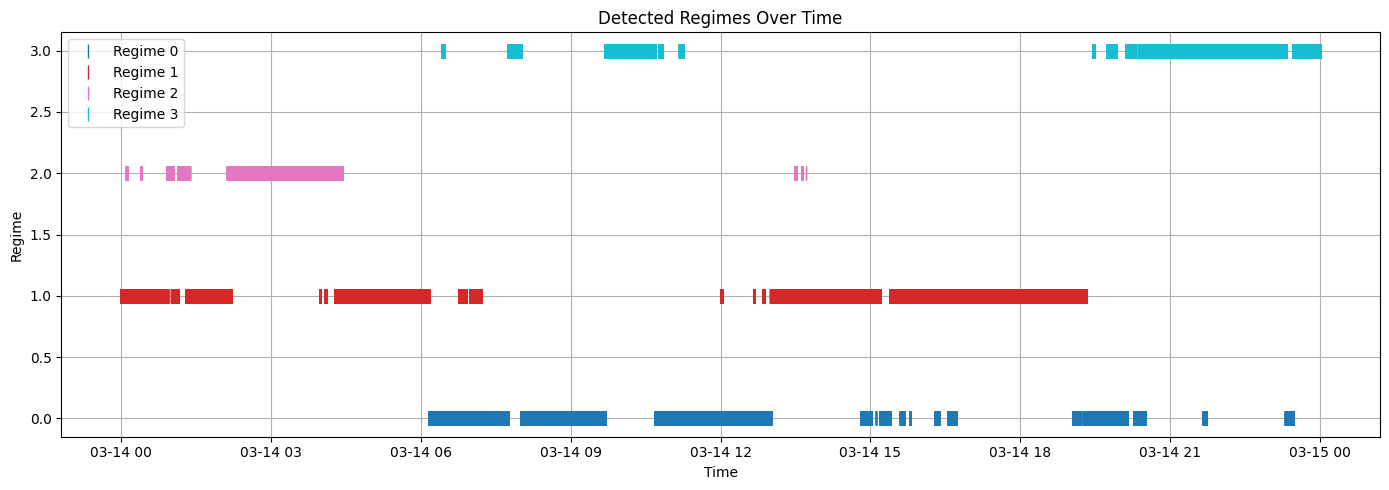

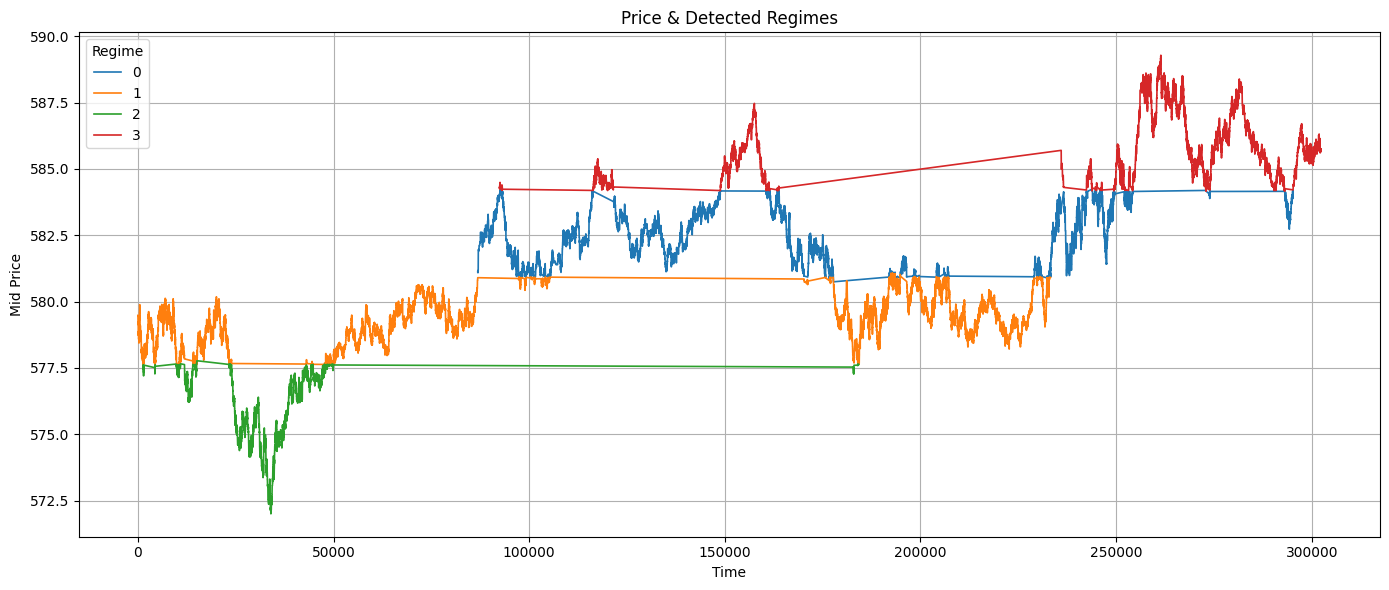

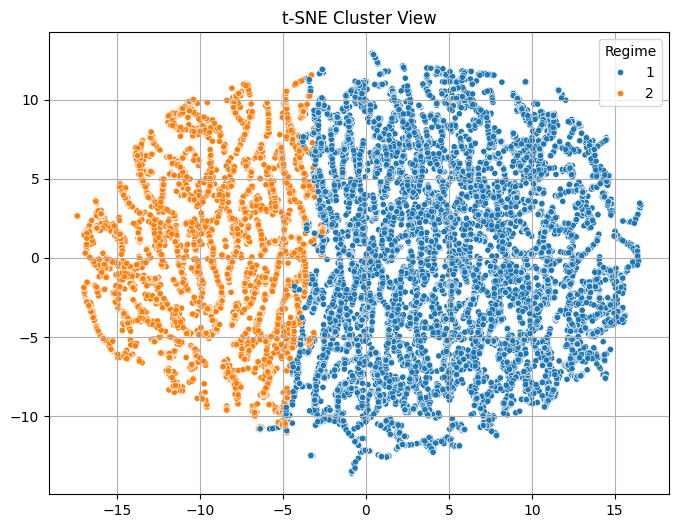

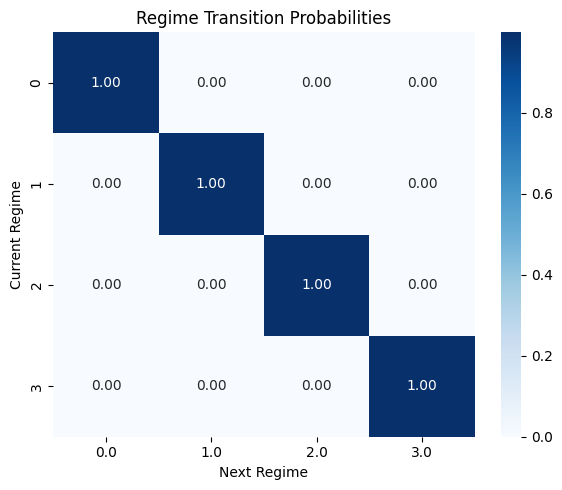

In [36]:
# Ensure `mid_price` is calculated in depth_features
depth_features = engineer_orderbook_features(depth_df)

depth_features["mid_price"] = (depth_df["BidPriceL1"] + depth_df["AskPriceL1"]) / 2

# Engineer features from the depth_df and add volatility features
depth_features = add_volatility_features(depth_features)

# Engineer trade features
trade_features = engineer_trade_features(trade_df, resample_to="1S")

# Merge depth and trade features
merged_features = merge_depth_trade_features(depth_features, trade_features)

# Explicitly add `mid_price` to the merged features
merged_features["mid_price"] = depth_features["mid_price"]

# Use `features_only` that includes the `mid_price`
# features_only = merged_features.drop(columns=["Time"])  # Drop 'Time' column, which isn't needed for PCA

# Normalize and reduce dimensions with PCA (using `features_only`)
# original_features["mid_price"] = (original_features["BidPriceL1"] + original_features["AskPriceL1"]) / 2

# Now you can proceed with the rest of the analysis, including clustering
scaled_features, _, original_features, pca_model = normalize_and_reduce(features_only, use_pca=True, n_components=3)

# Run K-Means clustering
kmeans_labels = run_kmeans(scaled_features, k=4)
original_features["mid_price"] = (original_features["BidPriceL1"] + original_features["AskPriceL1"]) / 2

# Visualize the results
plot_clusters_fancy(time_index, kmeans_labels, title="Detected Regimes Over Time")
plot_price_with_regimes(original_features, kmeans_labels, title="Price & Detected Regimes")
scaled_features_subsampled = scaled_features[:len(scaled_features)//10]
plot_tsne_2d(scaled_features_subsampled, kmeans_labels[:len(scaled_features)//10], title="t-SNE Cluster View")
# plot_tsne_2d(scaled_features, kmeans_labels, title="t-SNE Cluster View")

# Regime transition analysis
transition_matrix = regime_transition_matrix(kmeans_labels)
plot_transition_matrix(transition_matrix, title="Regime Transition Probabilities")


In [37]:
def plot_regime_radar(features, labels, regime_names=None):
    features = features.copy()
    features["regime"] = labels

    regime_profiles = features.groupby("regime").mean()
    regime_profiles = regime_profiles.drop(columns=["mid_price"], errors='ignore')  # drop if not needed

    # Normalize features for comparison
    regime_profiles = (regime_profiles - regime_profiles.min()) / (regime_profiles.max() - regime_profiles.min() + 1e-6)

    labels = list(regime_profiles.columns)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete loop

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

    for i, row in regime_profiles.iterrows():
        values = row.tolist()
        values += values[:1]  # complete loop
        label = f"Regime {i}" if regime_names is None else regime_names[i]
        ax.plot(angles, values, label=label)
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Regime Feature Profiles", fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()


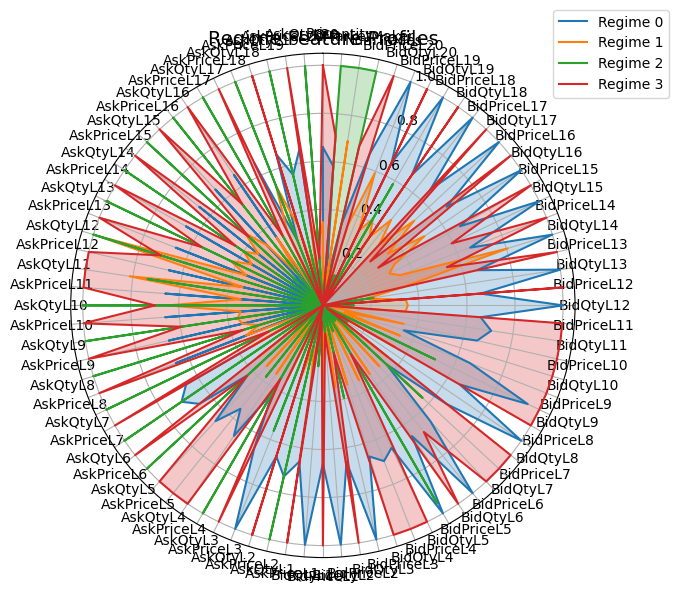

In [38]:
plot_regime_radar(original_features, kmeans_labels)



In [39]:
def get_top_regime_transitions(labels, top_n=2):
    df = pd.DataFrame({"regime": labels})
    df["next"] = df["regime"].shift(-1)
    transition_matrix = pd.crosstab(df["regime"], df["next"], normalize='index')

    top_transitions = {}
    for regime in transition_matrix.index:
        top = transition_matrix.loc[regime].sort_values(ascending=False).head(top_n)
        top_transitions[regime] = list(zip(top.index, top.values.round(3)))
    return transition_matrix, top_transitions


In [40]:
transition_matrix, top_transitions = get_top_regime_transitions(kmeans_labels)

for regime, transitions in top_transitions.items():
    print(f"From Regime {regime} most likely transitions to:")
    for next_regime, prob in transitions:
        print(f"  → Regime {next_regime} with probability {prob}")
    print()


From Regime 0 most likely transitions to:
  → Regime 0.0 with probability 0.998
  → Regime 1.0 with probability 0.001

From Regime 1 most likely transitions to:
  → Regime 1.0 with probability 0.998
  → Regime 0.0 with probability 0.001

From Regime 2 most likely transitions to:
  → Regime 2.0 with probability 0.997
  → Regime 1.0 with probability 0.003

From Regime 3 most likely transitions to:
  → Regime 3.0 with probability 0.999
  → Regime 0.0 with probability 0.001



In [43]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

def plot_umap_2d(data, labels, title="UMAP Cluster View"):
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(data)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', s=20)
    plt.title(title, fontsize=14)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Regime", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Use your scaled_features and kmeans_labels
plot_umap_2d(scaled_features, kmeans_labels)
